# 🐎 Horse Racing Analytics – Notebook 0: Setup, Data Extraction & Caching

Welcome to this notebook series on horse racing analytics.

We’ll be using a large, structured database containing over **30 years of UK and Irish racing data**, drawn from the `raceform.db` SQLite database. The goal of this project is to explore, visualise, and ultimately model horse racing outcomes using Python.

We are taking inspiration from the structure of *Football Analytics with Python & R* by Eric Eager — but instead of analysing sports plays, we’ll apply the same data science principles to **horse races**.

---

## 🎯 Goals of This Notebook

This setup notebook handles the **initial project configuration** and data preparation. Specifically, we will:

- Connect to the full SQLite database (`raceform.db`)
- Load the full history of **Flat racing** results (filtered from the `data_clean` table)
- Create a binary outcome column (`won`) for later analysis
- Export this cleaned subset to a **Feather file** (`data_flat.feather`) for fast re-use
- Verify structure, row count, and basic statistics

By the end of this notebook, we’ll have a **lightweight, fast-to-load copy** of our base dataset ready for use across all future notebooks — eliminating the need to re-query the database every time.

---

## 💾 About the Feather Format

**Feather** is a high-speed, binary format designed for data frames. It preserves types, loads in seconds, and takes up less space than CSV. It's ideal for analytical workflows like this, where the same structured dataset is used repeatedly.

We'll use it to **cache** the cleaned Flat-racing data so that other notebooks can instantly reload it without querying SQLite again.


## 🐎 Different Forms of Horse Racing = Different Contexts

Just like in football, where passing plays differ from running plays, horse racing includes multiple **forms of racing** that operate under different rules and dynamics.

Our dataset includes a `type` column that distinguishes between race types:

- `Flat`: No jumps, often influenced by draw and speed
- `Hurdle`: Smaller jumps, more attrition
- `Chase`: Larger jumps, higher DNF rates
- `NH Flat` or `Bumper`: Pre-jump schooling races
- `Hunter`: Steeplechases for amateur riders

We must avoid treating all races the same. Each form has unique dynamics, risks, and performance patterns.

> 🧠 So from this point onward, we’ll analyse races by type — starting with **Flat racing**, where stalls, draw, and pace play a central role.

In [18]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("../db/raceform.db")

# Load Flat races only
flat_df = pd.read_sql("""
    SELECT *
    FROM data_clean
    WHERE type = 'Flat';
""", conn)

conn.close()

# Filter for UK and IRE courses only
def is_uk_or_ire(course):
    course = course.lower()
    return '(ire)' in course or '(' not in course

#Load only Flat races from the database
flat_df = flat_df[flat_df['course'].apply(is_uk_or_ire)].copy()

# Add binary win flag
flat_df['won'] = (flat_df['pos'] == 1).astype(int)

# Save as new feather file
flat_df.to_feather("../db/data_flat_uk_ire.feather")

# Confirm
print("✅ UK+IRE Feather file created")
print("Rows saved:", len(flat_df))
print("Win rate:", f"{flat_df['won'].mean():.2%}")


✅ UK+IRE Feather file created
Rows saved: 473928
Win rate: 10.28%


In [19]:
import pandas as pd

# Load cached data
df = pd.read_feather("../db/data_flat_uk_ire.feather")

# Check structure
df.info()

# Quick context checks
print("Unique races:", df['race_id'].nunique())
print("Unique horses:", df['horse'].nunique())

# Preview columns
print("\nColumn list:")
print(df.columns.tolist())


<class 'pandas.core.frame.DataFrame'>
Index: 473928 entries, 13 to 1137235
Data columns (total 41 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         473928 non-null  object 
 1   course       473928 non-null  object 
 2   race_id      473928 non-null  int64  
 3   off          473928 non-null  object 
 4   race_name    473928 non-null  object 
 5   type         473928 non-null  object 
 6   class        473928 non-null  object 
 7   pattern      473928 non-null  object 
 8   rating_band  473928 non-null  object 
 9   age_band     473928 non-null  object 
 10  sex_rest     473928 non-null  object 
 11  dist         473928 non-null  object 
 12  going        473928 non-null  object 
 13  ran          473928 non-null  int64  
 14  num          473928 non-null  object 
 15  pos          473928 non-null  float64
 16  draw         466690 non-null  float64
 17  ovr_btn      473928 non-null  object 
 18  btn          473928 non-nul

## 🧠 Key Observations So Far (UK & IRE Flat Races Only)

After filtering for **Flat races held in the UK and Ireland**, we now have a clean, focused dataset containing:

### ✅ Structure & Coverage
- **473,928 total entries** (one per runner)
- **48,568 unique races**
- **64,010 unique horses**
- **41 columns**, covering race metadata, runner attributes, ratings, pedigree, comments, and outcomes

### 📉 Missing Data Highlights
- `draw`: present in ~98.5% of rows — mostly missing in very small fields or odd formats
- `or` (Official Rating): ~24% missing — may reflect unrated horses or unhandicapped races
- `rpr` (Racing Post Rating): ~96% coverage — very usable
- `ts` (TopSpeed Rating): ~85% coverage — usable with care
- `prize`: ~38% present — only awarded to placed horses
- `currency`: entirely empty — safely ignored

### 📌 Notes
- The dataset now **excludes international venues** (e.g. France, UAE, Hong Kong), which improves consistency across track layouts, draw systems, going conditions, and rules.
- This focused version is saved as `data_flat_uk_ire.feather` and will be used in all downstream analysis.



Win rate in Flat races: 10.28%


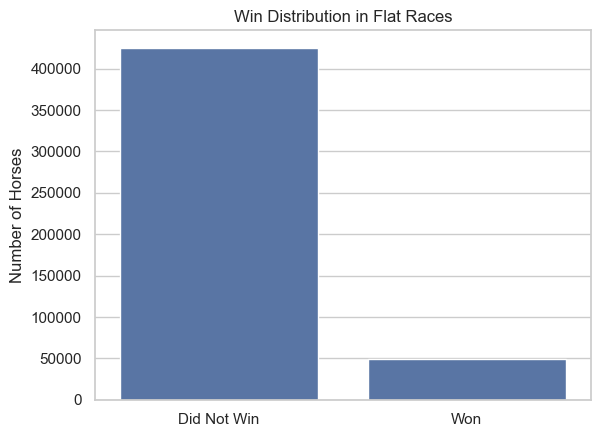

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')  # Optional: nice default style

# Filter for flat races only
flat_df = df[df['type'].str.lower() == 'flat'].copy()

# Recalculate win column (just to be safe)
flat_df['won'] = (flat_df['pos'] == 1).astype(int)

# Win rate in flat races
flat_win_rate = flat_df['won'].mean()
print(f"Win rate in Flat races: {flat_win_rate:.2%}")

# Bar chart for Flat races
sns.countplot(x='won', data=flat_df)
plt.title('Win Distribution in Flat Races')
plt.xticks([0, 1], ['Did Not Win', 'Won'])
plt.xlabel('')
plt.ylabel('Number of Horses')
plt.show()


---

## ✅ Conclusion

We’ve successfully connected to the full racing database, filtered the Flat racing data, and exported it to a `.feather` file for fast access in future notebooks.

Key outcomes:
- ✔️ Extracted all Flat races from the cleaned `data_clean` table
- ✔️ Added a `won` column to mark race winners
- ✔️ Saved the data locally as `data_flat.feather`
- ✔️ Verified row count and basic win rate

This lightweight file can now be reloaded instantly in all future notebooks — making our workflow much faster and more efficient.

We are now ready to begin structured analysis of horse- and race-level features, starting with `2_horse_attributes.ipynb`.

